# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [292]:
# import packages
import pandas as pd
import numpy as np
import requests as re
import os
import tweepy as tp
import json
import matplotlib.pyplot as plt
import seaborn as sb

In [293]:
# read WeRateDogs Twitter archive file on hand
twitter_archive = pd.read_csv(r'C:\Users\DE\Documents\Data wrangling_Udacity\twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [294]:
# write file tsv containing images
path = os.getcwd() # get the current path
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
if not os.path.exists(url.split('/')[-1]):
    response = re.get(url)
    with open(os.path.join(path, url.split('/')[-1]), mode = 'wb') as file:
        file.write(response.content)
        
# read image prediction tsv file into dataframe
image_prediction = pd.read_csv(r'C:\Users\DE\Documents\Data wrangling_Udacity\image-predictions.tsv', sep = '\t')

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [295]:
# query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# omit keys from submission to comply with Twitter's API terms and conditions
consumer_key = 'hidden'
consumer_secret = 'hidden'
access_token = 'hidden'
access_secret = 'hidden'

auth = tp.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tp.API(auth, wait_on_rate_limit=True)

In [296]:
# avoid gather data again in case the file is ready
if not os.path.exists('tweet_json.txt'):
    # list twitter id into array to query Twitter API for additional information
    list_id = twitter_archive.tweet_id.values

    # store each tweet's entire set of JSON data in a file called tweet_json.txt file
    fails_dict = {}
    with open('tweet_json.txt', 'w', encoding = 'utf-8') as f: 
        for id in list_id: 
            try: 
                tweet = api.get_status(id, tweet_mode='extended')
                json.dump(tweet._json, f)
                f.write('\n')
            except tp.errors.TweepyException as e: 
                fails_dict[id] = e
                pass   

In [297]:
# read tweet_json.txt line by line into dataframe 
# with tweet ID, retweet count, favorite count
df_list = []
with open('tweet_json.txt', 'r', encoding = 'utf-8') as f:
    for count, line in enumerate(f): 
        tweet_id = json.loads(line)['id']
        retweet_count = json.loads(line)['retweet_count']
        favorite_count = json.loads(line)['favorite_count']
        df_list.append({'tweet_id': tweet_id, 
        'retweet_count': retweet_count, 
        'favorite_count': favorite_count})

tweet_api = pd.DataFrame(df_list, columns = ['tweet_id', 'retweet_count', 'favorite_count'])       

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Quality Issues

1. Change datatype timestamp from string into datetime to exclude tweets beyond August 1st, 2017


In [298]:
# check datatype of timestamp column
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [299]:
# check data format
twitter_archive.timestamp

0       2017-08-01 16:23:56 +0000
1       2017-08-01 00:17:27 +0000
2       2017-07-31 00:18:03 +0000
3       2017-07-30 15:58:51 +0000
4       2017-07-29 16:00:24 +0000
                  ...            
2351    2015-11-16 00:24:50 +0000
2352    2015-11-16 00:04:52 +0000
2353    2015-11-15 23:21:54 +0000
2354    2015-11-15 23:05:30 +0000
2355    2015-11-15 22:32:08 +0000
Name: timestamp, Length: 2356, dtype: object

2. Rating denominator is equal to 0

In [300]:
twitter_archive[twitter_archive.rating_denominator == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None


3. Column expanded_urls has more 2 links, one in which is not twitter link or duplicated links

In [301]:
# randomly check the data format in expanded_urls
twitter_archive.expanded_urls.sample(10)

4       https://twitter.com/dog_rates/status/891327558...
1917    https://twitter.com/dog_rates/status/674291837...
674     https://twitter.com/dog_rates/status/789599242...
786     https://twitter.com/dog_rates/status/774757898...
1823    https://twitter.com/dog_rates/status/676533798...
1279    https://twitter.com/dog_rates/status/708845821...
1121    https://twitter.com/dog_rates/status/730924654...
2299    https://twitter.com/dog_rates/status/667065535...
1482                        https://vine.co/v/i5n2irFUYWv
841     https://twitter.com/dog_rates/status/759923798...
Name: expanded_urls, dtype: object

In [302]:
# check random data to see expanded_urls
twitter_archive.at[98, 'expanded_urls']

'https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.com/dog_rates/status/873213775632977920/photo/1,https://twitter.com/dog_rates/status/873213775632977920/photo/1'

4. Column name contains wrong names

In [303]:
# special character is not the right name is: a, the, ...
twitter_archive.name.sample(10)

526          Ito
504        Bauer
165         None
1129    Pupcasso
1474        None
1407      Reagan
1193           a
396        Sweet
889       Maggie
2303       Carll
Name: name, dtype: object

5. Tweet_ID = 740373189193256964 the dog has the rating is 14/10 

In [304]:
# check data based on url by visual assessment to see the rating
twitter_archive.at[twitter_archive[twitter_archive.tweet_id == 740373189193256964].index.values[0], 'expanded_urls']

'https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1'

6. Tweet_ID = 722974582966214656 the dog has the rating is 13/10

In [305]:
# check data based on url by visual assessment to see the rating
twitter_archive.at[twitter_archive[twitter_archive.tweet_id == 722974582966214656].index.values[0], 'expanded_urls']

'https://twitter.com/dog_rates/status/722974582966214656/photo/1'

7. Tweet_ID = 666287406224695296 the dog has the rating is 9/10

In [306]:
# check data based on url by visual assessment to see the rating
twitter_archive.at[twitter_archive[twitter_archive.tweet_id == 666287406224695296].index.values[0], 'expanded_urls']

'https://twitter.com/dog_rates/status/666287406224695296/photo/1'

8. Tweet_ID = 775096608509886464 does not exist, it is a duplication of Tweet_ID = 740373189193256964

In [307]:
# the id in the url is 740373189193256964 not 775096608509886464
twitter_archive.at[twitter_archive[twitter_archive.tweet_id == 775096608509886464].index.values[0], 'expanded_urls']

'https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1'

9. Remove data in twitter-archive-enhancement.csv for matching with the image_prediction.tsv - only data not beyond August 1st, 2017

In [308]:
twitter_archive.loc[twitter_archive.timestamp > '2017-08-01']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


#### Issue #10: Rmove retweets to keep only tweets to keep original rate point


In [309]:
twitter_archive[twitter_archive.retweeted_status_id.isnull()]
twitter_archive[twitter_archive.retweeted_status_user_id.isnull()]
twitter_archive[twitter_archive.retweeted_status_timestamp.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


### Tidiness Issues

1. Unpivot doggo, floofer, pupper, puppo into 1 column

2. Match image prediction columns in image_prediction.tsv to define dog tweet_id and columns retweet count and favorite count in tweet_api for analysis

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [310]:
# Make copies of original pieces of data
twitter_archive_cp = twitter_archive.copy()
image_prediction_cp = image_prediction.copy()
tweet_api_cp = tweet_api.copy()

### Quality issue

#### Issue #1:

##### Define: Change datatype timestamp from string into datetime to exclude tweets beyond August 1st, 2017

##### Code

In [311]:
# change datatype
twitter_archive_cp.timestamp = pd.to_datetime(twitter_archive_cp.timestamp)

# exclude data with timestamp beyond August 1st, 2017
twitter_archive_cp = twitter_archive_cp.loc[twitter_archive_cp.timestamp <= '2017-08-01']


##### Test

In [312]:
# check datatype
twitter_archive_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2354 entries, 2 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2354 non-null   int64              
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2354 non-null   datetime64[ns, UTC]
 4   source                      2354 non-null   object             
 5   text                        2354 non-null   object             
 6   retweeted_status_id         181 non-null    float64            
 7   retweeted_status_user_id    181 non-null    float64            
 8   retweeted_status_timestamp  181 non-null    object             
 9   expanded_urls               2295 non-null   object             
 10  rating_numerator            2354 non-null   int64           

In [313]:
# check the data in datetime to make sure not beyond 2017, Aug 1st.
(twitter_archive_cp.timestamp > '2017-08-01').sum()

0

#### Issue #2:

##### Define: Rating denominator is equal to 0
- Rating denominator should not be equal to 0, if exist, need to be excluded. 

##### Code

In [314]:
# exclude the record out of data
twitter_archive_cp = twitter_archive_cp[twitter_archive_cp.rating_denominator != 0]

##### Test

In [315]:
# test the result
(twitter_archive_cp.rating_denominator == 0).sum()

0

#### Issue #3: 

##### Define: Column expanded_urls has more than 2 links, one in which is not twitter link or duplicated links
- Tweet id has duplicated urls 
- Tweet id has other link apart from Twitter link


##### Code

In [316]:
import re

In [317]:
# create a serie to check url different than twitter url
arr = twitter_archive_cp['expanded_urls'].apply(lambda x: len(set(x.split(','))) if str(x) != 'nan' else x)
# check the rows that number of tweet_id having more than 1 url
print('number of tweet_id having more than 1 url', arr[(arr > 1)].sum()) 
print('number of tweet_id having more than 2 urls', arr[(arr > 2)].sum())

# apply for tweet_id having duplicated urls
getOnelink = lambda x: list(set(x.split(',')))[0] if (str(x) != 'nan' and len(list(set(x.split(',')))) == 1) else x
twitter_archive_cp['expanded_urls'] = twitter_archive_cp['expanded_urls'].apply(lambda x: getOnelink(x))

# apply for tweet_id having more than 1 unique url
def getTwitter(a): 
    return list(filter(lambda x: re.findall(r'.+twitter.com.+', x), a))[0]

getTwitterlink = lambda x: getTwitter(x.split(',')) if (str(x) != 'nan' and len(list(set(x.split(',')))) > 1) else x
twitter_archive_cp['expanded_urls'] = twitter_archive_cp['expanded_urls'].apply(lambda x: getTwitterlink(x))


number of tweet_id having more than 1 url 82.0
number of tweet_id having more than 2 urls 0.0


##### Test

In [318]:
# random check the column expanded_urls
twitter_archive_cp['expanded_urls'].sample(10)

1226    https://twitter.com/dog_rates/status/713919462...
1094    https://twitter.com/dog_rates/status/736736130...
1329    https://twitter.com/dog_rates/status/705898680...
874     https://twitter.com/dog_rates/status/761292947...
1182    https://twitter.com/dog_rates/status/718971898...
1251    https://twitter.com/dog_rates/status/710997087...
2012    https://twitter.com/dog_rates/status/672239279...
1045    https://twitter.com/dog_rates/status/743595368...
1338    https://twitter.com/dog_rates/status/705066031...
669     https://twitter.com/dog_rates/status/762699858...
Name: expanded_urls, dtype: object

In [319]:
# check row having more than one link
(twitter_archive_cp['expanded_urls'].apply(lambda x: len(x.split(',')) if str(x) != 'nan' else x) > 1).sum()

0

#### Issue #4: 

##### Define: Column name contains wrong names
- Special letter is not the right name for some tweet ids, such as a, the ...

##### Code

In [320]:
# define the lower string not the name of dogs
twitter_archive_cp.name = twitter_archive_cp.name.apply(lambda x: 'None' if x.lower() == x else x)


##### Test

In [321]:
twitter_archive_cp.name.sample(10)

1690       Asher
247         None
798         None
1269       Vince
2189        None
650       Bailey
1134     Coleman
742         None
1840        None
462     Herschel
Name: name, dtype: object

In [322]:
twitter_archive_cp.name[twitter_archive_cp.name.str.lower() == twitter_archive_cp.name]

Series([], Name: name, dtype: object)

#### Issue #5, #6, #7:

##### Define: 
- Tweet_ID = 740373189193256964 the dog has the rating is 14/10 
- Tweet_ID = 722974582966214656 the dog has the rating is 13/10
- Tweet_ID = 666287406224695296 the dog has the rating is 9/10

##### Code

In [323]:
# set function to chanfe value numerator, denominator by twwet_id
def getIndex(tweet_id):
    return twitter_archive_cp[twitter_archive_cp.tweet_id == tweet_id].index.values[0]    

In [324]:
list_id = [740373189193256964, 722974582966214656, 666287406224695296]
list_no =[14,13,9]
list_de = [10]*3

In [325]:
# change the cell value for numerator and denominator values
for i,j,k in zip(list_id, list_no, list_de):
    twitter_archive_cp.at[getIndex(i), 'rating_numerator'] = j
    twitter_archive_cp.at[getIndex(i), 'rating_denominator'] = k


##### Test

In [326]:
twitter_archive_cp[twitter_archive_cp.tweet_id.isin(list_id)]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,14,10,None,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,13,10,None,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,9,10,None,None,None,None,None


#### Issue #8:

##### Define: Tweet_ID = 775096608509886464 does not exist, it is a duplication of Tweet_ID = 740373189193256964
- Remove Tweet_ID = 775096608509886464 out of dataset.

##### Code

In [327]:
# remove the row with this tweet id
twitter_archive_cp = twitter_archive_cp.loc[twitter_archive_cp.tweet_id != 775096608509886464]

##### Test

In [328]:
twitter_archive_cp.loc[twitter_archive_cp.tweet_id == 775096608509886464]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Issue #9: 

##### Define: Remove data in twitter-archive-enhancement.csv for matching with the image_prediction.tsv - only data not beyond August 1st, 2017

##### Code

In [329]:
twitter_archive_cp = twitter_archive_cp.loc[twitter_archive_cp.timestamp <= '2017-08-01']

##### Test

In [330]:
twitter_archive_cp.loc[twitter_archive_cp.timestamp > '2017-08-01']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Issue #10: Rmove retweets to keep only tweets to keep original rate point


##### Define: Remove retweets (text starting with RT @) 

##### Code

In [331]:
twitter_archive_cp = twitter_archive_cp[twitter_archive_cp.retweeted_status_id.isnull()]
twitter_archive_cp = twitter_archive_cp[twitter_archive_cp.retweeted_status_user_id.isnull()]
twitter_archive_cp = twitter_archive_cp[twitter_archive_cp.retweeted_status_timestamp.isnull()]

##### Test

In [332]:
twitter_archive_cp[twitter_archive_cp.retweeted_status_id.isnull() == False]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Tidiness issue

#### Issue #1: 

##### Define: the dog stage is one variable and hence should form single column

##### Code

In [333]:
twitter_archive_cp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2172 entries, 2 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2172 non-null   int64              
 1   in_reply_to_status_id       77 non-null     float64            
 2   in_reply_to_user_id         77 non-null     float64            
 3   timestamp                   2172 non-null   datetime64[ns, UTC]
 4   source                      2172 non-null   object             
 5   text                        2172 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               2115 non-null   object             
 10  rating_numerator            2172 non-null   int64           

In [334]:
dog_type = ['doggo', 'floofer', 'pupper', 'puppo']

In [335]:
# unpivot columns in dog_type
df1 = pd.melt(twitter_archive_cp, id_vars=twitter_archive_cp.columns.difference(dog_type), var_name='dog_type_name_column', value_name='dog_type')

In [336]:
# split dataset into None dog_type and dog_type in ['doggo', 'floofer', 'pupper', 'puppo'] and remove duplicates
df2 = df1.drop('dog_type_name_column', axis=1).loc[df1.dog_type == 'None'].drop_duplicates() # all tweet_id
df3 = df1.loc[df1.dog_type == df1.dog_type_name_column].drop('dog_type_name_column', axis=1).drop_duplicates() # tweet_id having dogtype

In [337]:
# df4 will exclude tweet_id having dogtype from df2 (real None dog type)
df4 = df2.loc[~df2.tweet_id.isin(df3.tweet_id)]
twitter_archive_cp = pd.concat([df3, df4], axis=0)

In [338]:
# reset index for twitter_archive_cp
twitter_archive_cp.reset_index(drop=True)

,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,name,rating_denominator,rating_numerator,retweeted_status_id,retweeted_status_timestamp,retweeted_status_user_id,source,text,timestamp,tweet_id,dog_type
0,https://twitter.com/dog_rates/status/890240255...,NaN,NaN,Cassie,10,14,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,2017-07-26 15:59:51+00:00,890240255349198849,doggo
1,https://twitter.com/dog_rates/status/884162670...,NaN,NaN,Yogi,10,12,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,2017-07-09 21:29:42+00:00,884162670584377345,doggo
2,https://twitter.com/dog_rates/status/872967104...,NaN,NaN,None,10,12,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,2017-06-09 00:02:31+00:00,872967104147763200,doggo
3,https://twitter.com/dog_rates/status/871515927...,NaN,NaN,Napolean,10,12,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,2017-06-04 23:56:03+00:00,871515927908634625,doggo
4,https://twitter.com/animalcog/status/871075758...,NaN,NaN,None,10,14,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,2017-06-03 20:33:19+00:00,871102520638267392,doggo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2179,https://twitter.com/dog_rates/status/666049248...,NaN,NaN,None,10,5,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,2015-11-16 00:24:50+00:00,666049248165822465,None
2180,https://twitter.com/dog_rates/status/666044226...,NaN,NaN,None,10,6,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,2015-11-16 00:04:52+00:00,666044226329800704,None
2181,https://twitter.com/dog_rates/status/666033412...,NaN,NaN,None,10,9,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,2015-11-15 23:21:54+00:00,666033412701032449,None
2182,https://twitter.com/dog_rates/status/666029285...,NaN,NaN,None,10,7,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,2015-11-15 23:05:30+00:00,666029285002620928,None


##### Test

In [339]:
twitter_archive_cp['dog_type'].unique()

array(['doggo', 'floofer', 'pupper', 'puppo', 'None'], dtype=object)

In [340]:
twitter_archive_cp.shape

(2184, 14)

#### Issue #2:

##### Define: nformation about one type of observational unit (tweets) is spread across three different files/dataframes

##### Code:

In [341]:
image_prediction_cp.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [342]:
tweet_api_cp.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,6953,33614
1,892177421306343426,5256,29150
2,891815181378084864,3462,21935
3,891689557279858688,7163,36677
4,891327558926688256,7703,35066


In [343]:
# merge prediction result from image_prediction_cp into twitter_archive_cp
twitter_archive_cp = twitter_archive_cp.merge(image_prediction_cp[['tweet_id', 'p1_dog', 'p2_dog', 'p3_dog']], how='left', on='tweet_id')


In [344]:
# merge retweet count and favorite count into twitter_archive_cp
twitter_archive_cp = twitter_archive_cp.merge(tweet_api_cp, how='left', on='tweet_id')

##### Test

In [345]:
twitter_archive_cp.shape

(2184, 19)

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [352]:
if os.path.exists('twitter_archive_master.csv'):
    os.remove('twitter_archive_master.csv') 
    twitter_archive_cp.to_csv('twitter_archive_master.csv', index=False)
else: 
    twitter_archive_cp.to_csv('twitter_archive_master.csv', index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [353]:
# import master file
master = pd.read_csv(r'C:\Users\DE\Documents\Data wrangling_Udacity\twitter_archive_master.csv')
master.shape

(2184, 19)

In [354]:
# check duplicates number is 14 tweet_ids = 2366 - 2352 due to difference dog type
master[master.duplicated(subset='tweet_id', keep='last') == True]['tweet_id'].count()

12

In [355]:
# show all duplcates
master[master.duplicated(subset='tweet_id', keep=False) == True].sort_values(by='tweet_id')

,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,name,rating_denominator,rating_numerator,retweeted_status_id,retweeted_status_timestamp,retweeted_status_user_id,source,text,timestamp,tweet_id,dog_type,p1_dog,p2_dog,p3_dog,retweet_count,favorite_count
81,https://twitter.com/dog_rates/status/733109485...,NaN,NaN,None,10,12,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...","Like father (doggo), like son (pupper). Both 1...",2016-05-19 01:38:16+00:00,733109485275860992,doggo,True,True,False,15418.0,49050.0
169,https://twitter.com/dog_rates/status/733109485...,NaN,NaN,None,10,12,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...","Like father (doggo), like son (pupper). Both 1...",2016-05-19 01:38:16+00:00,733109485275860992,pupper,True,True,False,15418.0,49050.0
77,https://twitter.com/dog_rates/status/741067306...,NaN,NaN,None,10,12,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is just downright precious af. 12/10 for ...,2016-06-10 00:39:48+00:00,741067306818797568,doggo,True,True,True,2793.0,8814.0
162,https://twitter.com/dog_rates/status/741067306...,NaN,NaN,None,10,12,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is just downright precious af. 12/10 for ...,2016-06-10 00:39:48+00:00,741067306818797568,pupper,True,True,True,2793.0,8814.0
68,https://twitter.com/dog_rates/status/751583847...,NaN,NaN,None,10,5,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending it pictures that don't eve...,2016-07-09 01:08:47+00:00,751583847268179968,doggo,True,False,False,1000.0,4079.0
147,https://twitter.com/dog_rates/status/751583847...,NaN,NaN,None,10,5,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending it pictures that don't eve...,2016-07-09 01:08:47+00:00,751583847268179968,pupper,True,False,False,1000.0,4079.0
60,https://twitter.com/dog_rates/status/759793422...,NaN,NaN,Maggie,10,12,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",2016-07-31 16:50:42+00:00,759793422261743616,doggo,True,True,True,1753.0,5554.0
143,https://twitter.com/dog_rates/status/759793422...,NaN,NaN,Maggie,10,12,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",2016-07-31 16:50:42+00:00,759793422261743616,pupper,True,True,True,1753.0,5554.0
50,https://vine.co/v/5rgu2Law2ut,NaN,NaN,None,10,12,NaN,NaN,NaN,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",2016-09-29 01:42:20+00:00,781308096455073793,doggo,NaN,NaN,NaN,2369.0,6696.0
132,https://vine.co/v/5rgu2Law2ut,NaN,NaN,None,10,12,NaN,NaN,NaN,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...","Pupper butt 1, Doggo 0. Both 12/10 https://t.c...",2016-09-29 01:42:20+00:00,781308096455073793,pupper,NaN,NaN,NaN,2369.0,6696.0


In [351]:
master[master.duplicated(subset='tweet_id', keep=False) == True].sort_values(by='tweet_id').at[81, 'expanded_urls']

'https://twitter.com/dog_rates/status/733109485275860992/photo/1'

In [ ]:
## Tweet_ID having the biggest retweets and favorites
# check distinction in the other 2 datasets to make sure left join without duplications
print('Check distinct rows in tweet_api', tweet_api['tweet_id'].nunique() == tweet_api['tweet_id'].shape[0])
print('Check distinct rows in image prediction', image_prediction['tweet_id'].nunique() == image_prediction['tweet_id'].shape[0]) 

Check distinct rows in tweet_api True
Check distinct rows in image prediction True


In [356]:
## Tweet_ID having the biggest retweets and favorites
# sort values from largest to smallest to see the largest retweets and favoites
master.sort_values(by='favorite_count', ascending=False).head()


,expanded_urls,in_reply_to_status_id,in_reply_to_user_id,name,rating_denominator,rating_numerator,retweeted_status_id,retweeted_status_timestamp,retweeted_status_user_id,source,text,timestamp,tweet_id,dog_type,p1_dog,p2_dog,p3_dog,retweet_count,favorite_count
75,https://twitter.com/dog_rates/status/744234799...,NaN,NaN,None,10,13,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo realizing you can stand in a po...,2016-06-18 18:26:18+00:00,744234799360020481,doggo,True,False,True,70116.0,143796.0
340,https://twitter.com/dog_rates/status/822872901...,NaN,NaN,None,10,13,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,2017-01-21 18:26:02+00:00,822872901745569793,puppo,True,True,True,39660.0,123296.0
724,https://twitter.com/dog_rates/status/807106840...,NaN,NaN,Stephan,10,13,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,2016-12-09 06:17:20+00:00,807106840509214720,None,True,True,True,51274.0,110832.0
104,https://twitter.com/dog_rates/status/866450705...,NaN,NaN,Jamesy,10,13,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",This is Jamesy. He gives a kiss to every other...,2017-05-22 00:28:40+00:00,866450705531457537,pupper,True,True,True,29995.0,108243.0
79,https://twitter.com/dog_rates/status/739238157...,NaN,NaN,None,10,13,NaN,NaN,NaN,"<a href=""http://twitter.com/download/iphone"" r...",Here's a doggo blowing bubbles. It's downright...,2016-06-04 23:31:25+00:00,739238157791694849,doggo,True,True,True,52484.0,106478.0


In [357]:
## Tweet_ID having the biggest retweets and favorites
# check the url of tweet which has the biggest number of retweets and favorites
master.at[85,'expanded_urls']

'https://twitter.com/dog_rates/status/719991154352222208/photo/1'

In [358]:
## Average of rating numerator per denominator
# calculate the average of rating numerator per denominator
from numpy import average
average(master.drop_duplicates('tweet_id').rating_numerator/master.drop_duplicates('tweet_id').rating_denominator)

1.2242855747690002

In [359]:
## Prediction Rate
# drop duplicates on tweet_id level
master_1 = master.drop_duplicates('tweet_id')
# check total tweet ids which has predictions
total_pre = master_1.loc[(master_1.p1_dog + master_1.p2_dog + master_1.p3_dog).isna() == False].shape[0]
# check number of tweet ids which has at least 1 True prediction
one_true_pre = master_1.loc[master_1.p1_dog + master_1.p2_dog + master_1.p3_dog > 0].shape[0]
# check number of tweet ids which has all True prediction
all_true_pre = master_1.loc[master_1.p1_dog + master_1.p2_dog + master_1.p3_dog == 3].shape[0]
# rate True prediction
print('At least one True prediction', one_true_pre/total_pre)
print('All True prediction', all_true_pre/total_pre)
total_pre

At least one True prediction 0.8458835341365462
All True prediction 0.6034136546184738


1992

### Insights:
1. Tweet ID = 744234799360020481 is the tweet with the highest retweet counts and favorite counts in the dataset. This is the url: https://twitter.com/dog_rates/status/744234799360020481/video/1
2. The average point of dog rating is 1.22, greater than 1, which means that there exists more tweets using the rating system that rating numerator greater than rating denominator.
3. Prediction rate: 
- At least one True prediction: 0.844187168355041
- All True prediction: 0.5991316931982634

### Visualization

In this visualization, my interest is to see the relationship between the rating and the favorite count and retweet count.

In [360]:
# create rate point column
master_1 = master.drop_duplicates('tweet_id')
master_1['rate_point'] = master_1['rating_numerator']/master_1['rating_denominator']
master_1['rate_point']

C:\Users\DE\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0       1.4
1       1.2
2       1.2
3       1.2
4       1.4
       ... 
2179    0.5
2180    0.6
2181    0.9
2182    0.7
2183    0.8
Name: rate_point, Length: 2172, dtype: float64

Text(0.5, 1.0, 'Retweet count for rate point > 2 (outlier)')

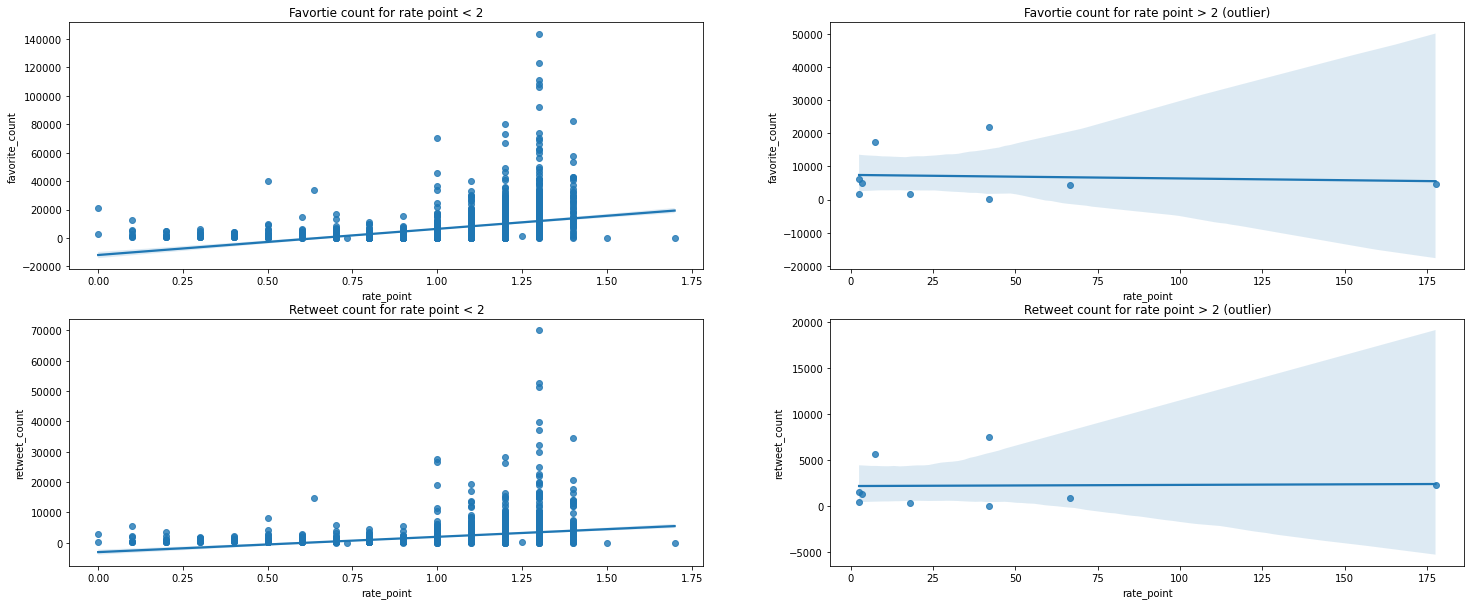

In [361]:
# create fig and add subplot
fix = plt.figure(figsize=(25,10))
ax1 = plt.subplot(2,2,1)
ax2 = plt.subplot(2,2,2)
ax3 = plt.subplot(2,2,3)
ax4 = plt.subplot(2,2,4)

# regplot
sb.regplot(data=master_1[master_1.rate_point<2], x='rate_point',y='favorite_count', fit_reg=True, ax=ax1)
ax1.set_title('Favortie count for rate point < 2')

sb.regplot(data=master_1[master_1.rate_point<2], x='rate_point',y='retweet_count', fit_reg=True, ax=ax3)
ax3.set_title('Retweet count for rate point < 2')

sb.regplot(data=master_1[master_1.rate_point>2], x='rate_point',y='favorite_count', fit_reg=True, ax=ax2)
ax2.set_title('Favortie count for rate point > 2 (outlier)')

sb.regplot(data=master_1[master_1.rate_point>2], x='rate_point',y='retweet_count', fit_reg=True, ax=ax4)
ax4.set_title('Retweet count for rate point > 2 (outlier)')


There is a slight positive correlation between the rating point and the retweet and favorite count, which means that if the tweet has the higher rating, the chance it will be retweeted or liked will be higher.